In [115]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers



In [70]:
train_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/training'
test_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/validation'

In [107]:
batch_size = 32
img_height = 224
img_width = 224

In [132]:
train_data_gen = ImageDataGenerator(rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        validation_split=0.20,) 

# Use flow_from_directory for the training dataset
train_ds = train_data_gen.flow_from_directory(
    train_img_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='training', 
    seed=123,
    shuffle=True  
)
valid_ds = train_data_gen.flow_from_directory(
    train_img_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='validation', 
    seed=123,
    shuffle=True  
)

Found 1108 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


In [133]:
test_data_gen = ImageDataGenerator(rescale=1./255,)  # You may adjust other parameters as needed

# Use flow_from_directory for the test dataset
test_ds = test_data_gen.flow_from_directory(
    test_img_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Assuming label_mode='int' in your original code
    shuffle=False  # Set to True if you want to shuffle the data
)

Found 248 images belonging to 3 classes.


In [134]:
cl=test_ds.class_indices
print(cl)

{'01-minor': 0, '02-moderate': 1, '03-severe': 2}


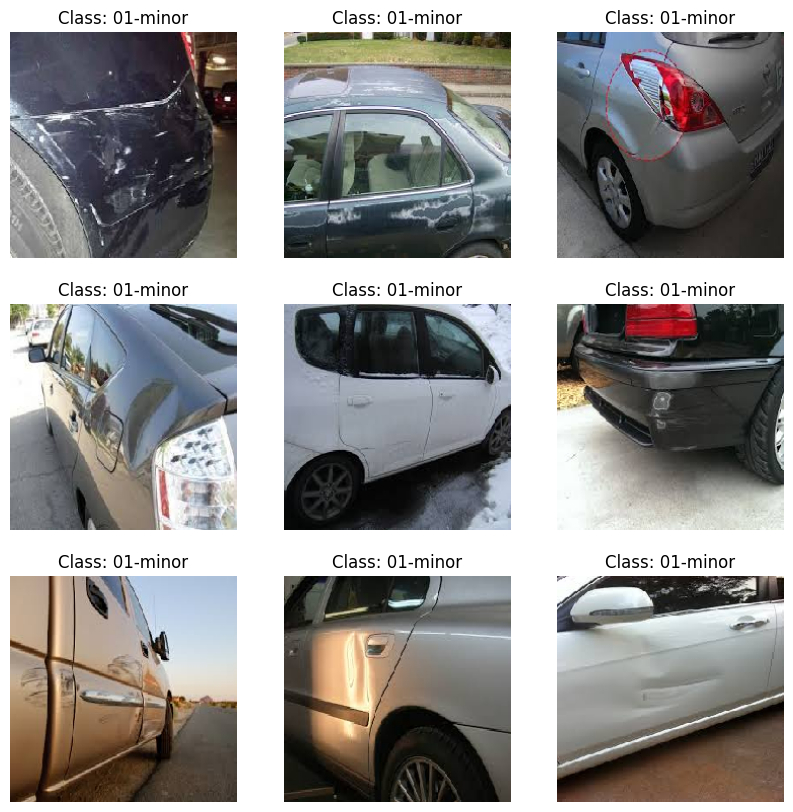

In [135]:
def plot_images_from_dataset(dataset, num_images=9):
    # Fetch a batch of images and labels from the dataset
    images, labels = next(iter(dataset))

    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        # Map the label index back to the original class name
        label_index = labels[i].argmax()  # Assumes one-hot encoding
        class_name = next(key for key, value in cl.items() if value == label_index)
        
        plt.title(f"Class: {class_name}")
        plt.axis("off")
    plt.show()


# Assuming test_ds is your dataset
plot_images_from_dataset(test_ds)


# First Model : Resnet

In [97]:
# Use ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model by adding custom top layers for multi-class classification
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))


for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_32 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 256)               131328    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                      

In [98]:
epochs=50

# Train the model
history_resnet = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    verbose=1,
)

# Save training and validation histories for later analysis
all_train_histories = [history_resnet.history['accuracy']]
all_val_histories = [history_resnet.history['val_accuracy']]


Epoch 1/50
35/35 [==============================] - 26s 628ms/step - loss: 1.4762 - accuracy: 0.3231 - val_loss: 1.0882 - val_accuracy: 0.3345
Epoch 2/50
35/35 [==============================] - 20s 569ms/step - loss: 1.2986 - accuracy: 0.3339 - val_loss: 1.0692 - val_accuracy: 0.3818
Epoch 3/50
35/35 [==============================] - 20s 586ms/step - loss: 1.1889 - accuracy: 0.3773 - val_loss: 1.0634 - val_accuracy: 0.3927
Epoch 4/50
35/35 [==============================] - 20s 571ms/step - loss: 1.1352 - accuracy: 0.3691 - val_loss: 1.0542 - val_accuracy: 0.3927
Epoch 5/50
35/35 [==============================] - 20s 576ms/step - loss: 1.1288 - accuracy: 0.3863 - val_loss: 1.0477 - val_accuracy: 0.4145
Epoch 6/50
35/35 [==============================] - 20s 580ms/step - loss: 1.0933 - accuracy: 0.3881 - val_loss: 1.0377 - val_accuracy: 0.5055
Epoch 7/50
35/35 [==============================] - 20s 583ms/step - loss: 1.0879 - accuracy: 0.3872 - val_loss: 1.0336 - val_accuracy: 0.5164

In [99]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Get predictions for the test set
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)



8/8 [==============================] - 1s 104ms/step - loss: 0.8539 - accuracy: 0.5968
Test Accuracy: 59.68%
Test Loss: 0.8539
8/8 [==============================] - 2s 103ms/step


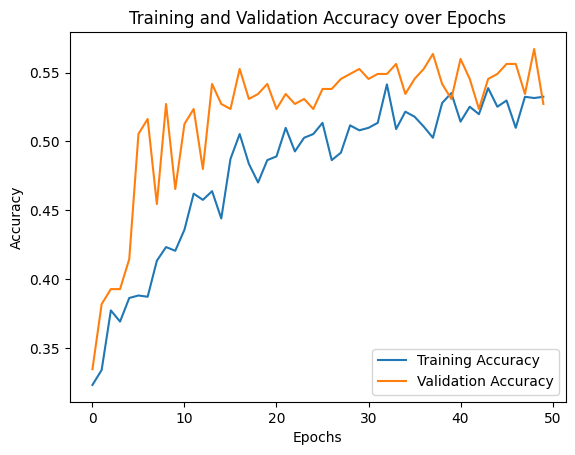

8/8 [==============================] - 1s 105ms/step - loss: 0.8539 - accuracy: 0.5968
Test Accuracy: 59.68%
Test Loss: 0.8539


In [100]:
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Testing code
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

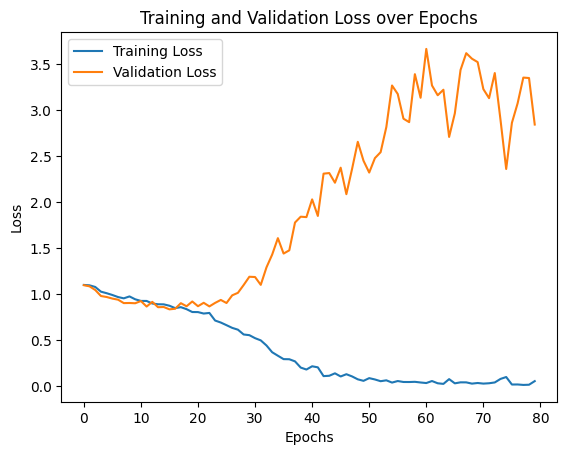

In [102]:
all_train_loss_histories = [history_resnet.history['loss']]
all_val_loss_histories = [history_resnet.history['val_loss']]

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')


              precision    recall  f1-score   support

           0       0.70      0.71      0.70        82
           1       0.43      0.37      0.40        75
           2       0.62      0.68      0.65        91

    accuracy                           0.60       248
   macro avg       0.58      0.59      0.58       248
weighted avg       0.59      0.60      0.59       248



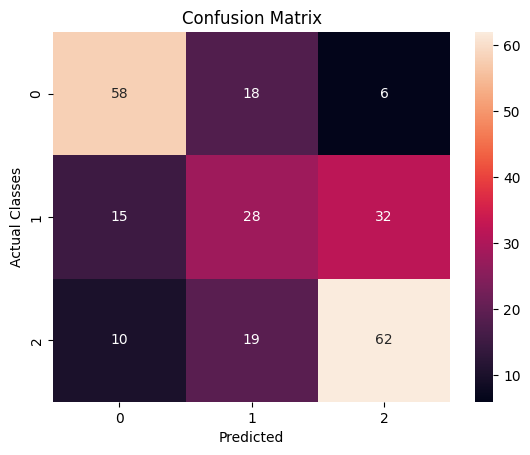

In [101]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
true_labels = test_ds.classes
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_labels))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()


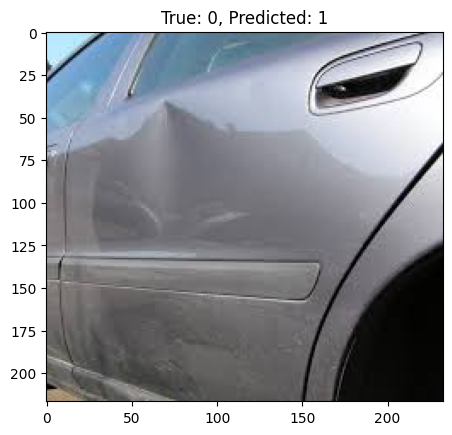

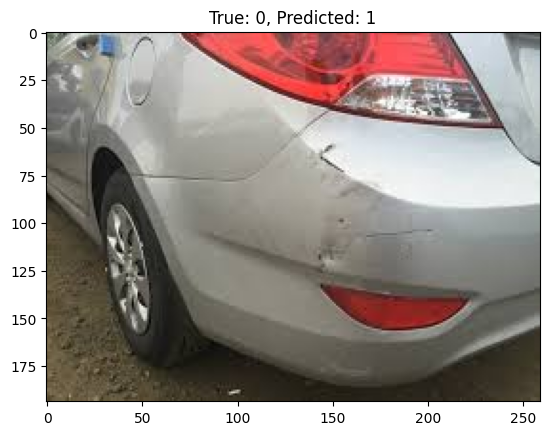

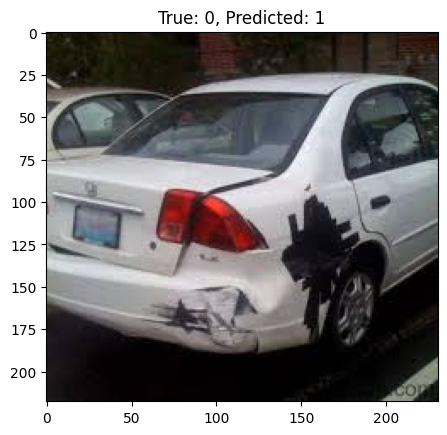

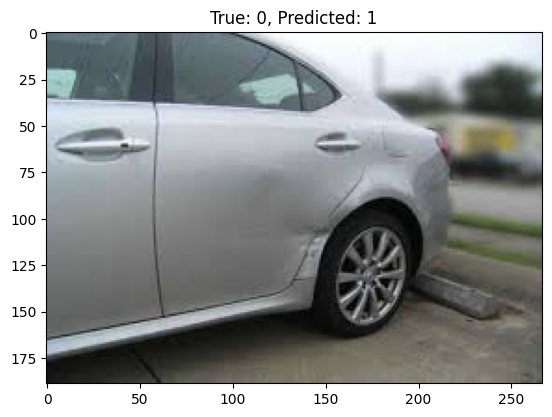

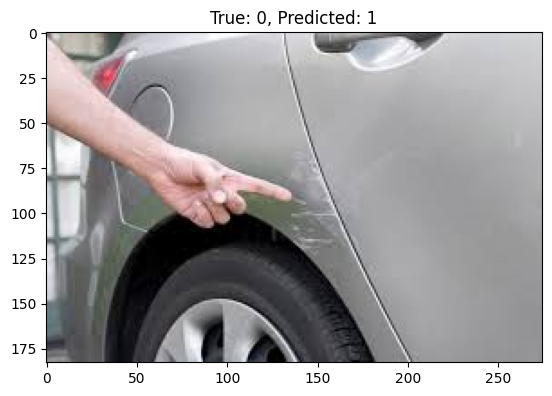

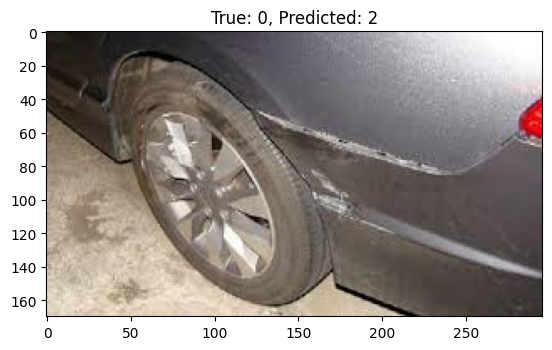

In [113]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]
num_images_to_display = 6
for i in range(min(num_images_to_display, len(misclassified_indices))):
    index = misclassified_indices[i]
    
    # Load and display the misclassified image
    image = plt.imread(valid_ds.filepaths[index])
    plt.imshow(image)
    
    # Display true and predicted labels
    true_label = valid_ds.classes[index]
    predicted_label = predicted_labels[index]
    
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()

# Second Model: 4D Model

In [145]:
model_4d = models.Sequential()

model_4d.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
model_4d.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4d.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4d.add(layers.MaxPooling2D((2, 2)))
model_4d.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_4d.add(layers.MaxPooling2D((2, 2)))
model_4d.add(layers.Conv2D(384, (3, 3), activation='relu'))
model_4d.add(layers.MaxPooling2D((2, 2)))
model_4d.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_4d.add(layers.MaxPooling2D((2, 2)))
model_4d.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model_4d.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from Conv2D layers
model_4d.add(layers.Flatten())

# Add fully connected layers with specified parameters and regularization
model_4d.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4d.add(layers.Dropout(0.5))
model_4d.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4d.add(layers.Dropout(0.5))
model_4d.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4d.add(layers.Dense(3, activation='softmax'))


In [146]:
model_4d.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'AUC'])

model_4d.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_92 (Conv2D)          (None, 220, 220, 64)      18496     
                                                                 
 conv2d_93 (Conv2D)          (None, 218, 218, 128)     73856     
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 109, 109, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_94 (Conv2D)          (None, 107, 107, 256)     295168    
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 53, 53, 256)       0         
 ng2D)                                               

In [147]:
epochs=50

# Train the model
history = model_4d.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,  # Use a part of train_ds as validation data
    verbose=1,
)

# Save training and validation histories for later analysis
all_train_histories = [history.history['accuracy']]
all_val_histories = [history.history['val_accuracy']]


Epoch 1/50
35/35 [==============================] - 26s 624ms/step - loss: 5.0613 - accuracy: 0.3565 - auc: 0.5219 - val_loss: 4.3673 - val_accuracy: 0.3382 - val_auc: 0.5456
Epoch 2/50
35/35 [==============================] - 21s 583ms/step - loss: 3.8634 - accuracy: 0.3357 - auc: 0.5194 - val_loss: 3.3937 - val_accuracy: 0.3382 - val_auc: 0.5616
Epoch 3/50
35/35 [==============================] - 21s 595ms/step - loss: 3.0634 - accuracy: 0.3493 - auc: 0.5400 - val_loss: 2.7470 - val_accuracy: 0.3600 - val_auc: 0.5990
Epoch 4/50
35/35 [==============================] - 21s 592ms/step - loss: 2.5416 - accuracy: 0.3917 - auc: 0.5878 - val_loss: 2.3437 - val_accuracy: 0.4982 - val_auc: 0.6829
Epoch 5/50
35/35 [==============================] - 21s 603ms/step - loss: 2.1812 - accuracy: 0.4711 - auc: 0.6731 - val_loss: 2.0307 - val_accuracy: 0.5236 - val_auc: 0.7100
Epoch 6/50
35/35 [==============================] - 21s 597ms/step - loss: 1.9622 - accuracy: 0.4946 - auc: 0.6907 - val_loss

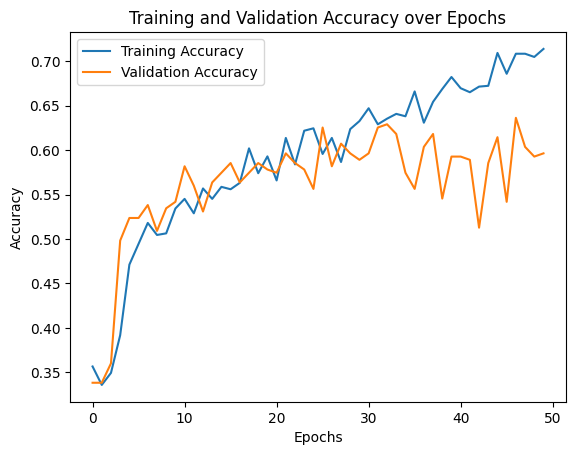

8/8 [==============================] - 1s 126ms/step - loss: 1.0837 - accuracy: 0.6048 - auc: 0.8122


ValueError: too many values to unpack (expected 2)

In [148]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Testing code
test_loss, test_accuracy = model_4d.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

8/8 [==============================] - 1s 125ms/step
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        82
           1       0.44      0.41      0.42        75
           2       0.64      0.71      0.67        91

    accuracy                           0.60       248
   macro avg       0.60      0.60      0.60       248
weighted avg       0.60      0.60      0.60       248



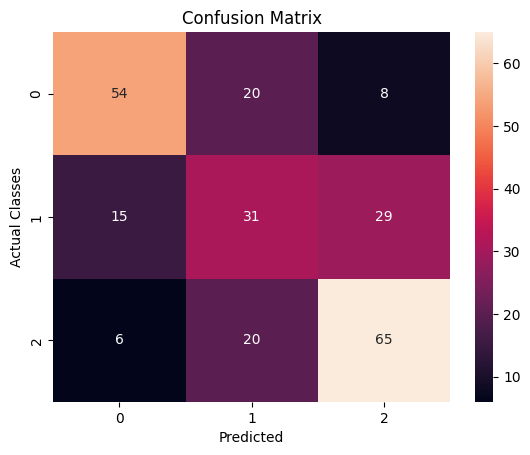

In [149]:
# Confusion matrix
true_labels = test_ds.classes
predictions = model_4d.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_labels))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

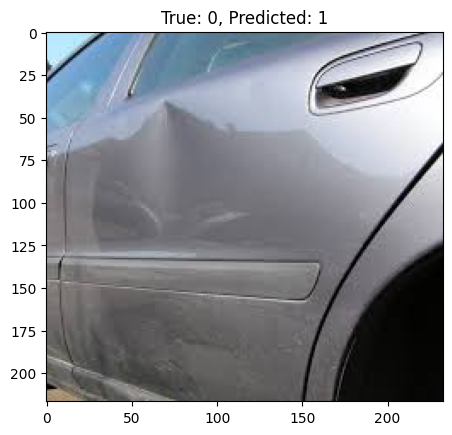

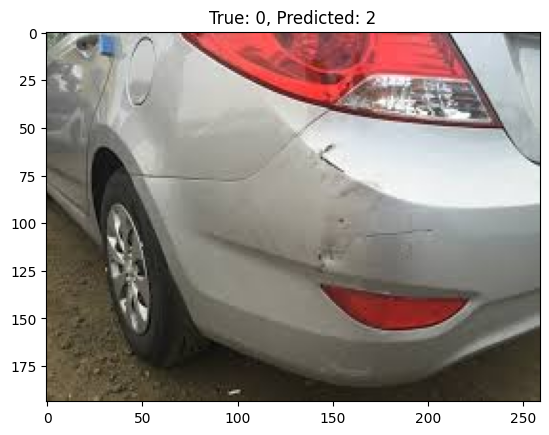

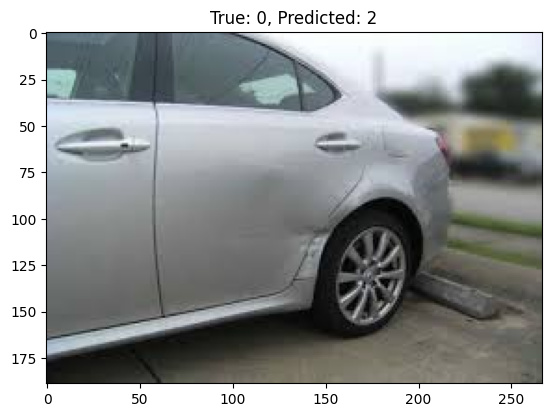

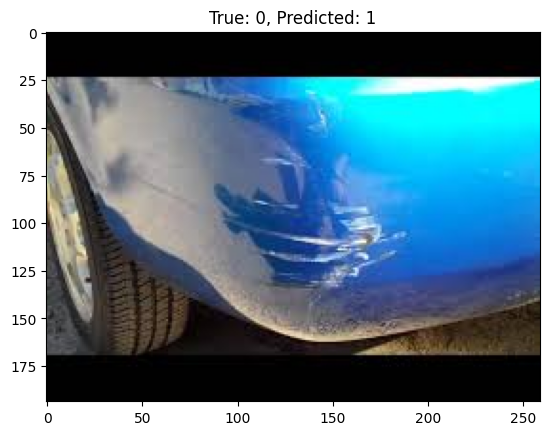

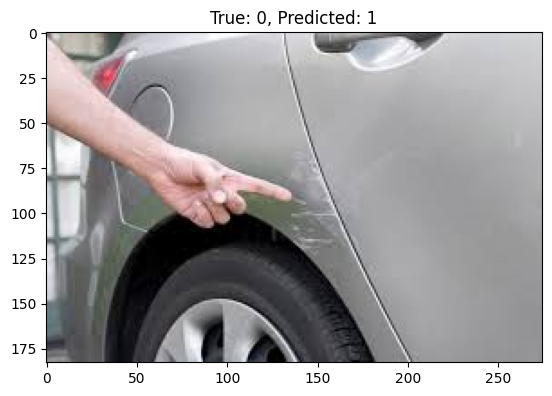

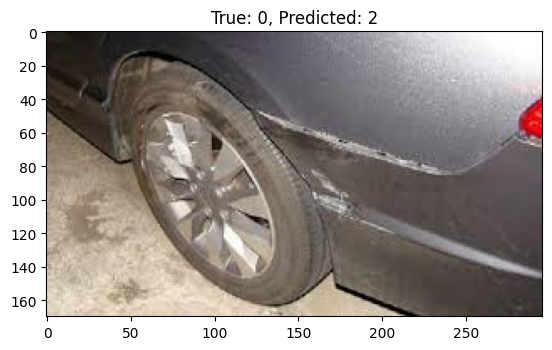

In [150]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]
num_images_to_display = 6
for i in range(min(num_images_to_display, len(misclassified_indices))):
    index = misclassified_indices[i]
    
    # Load and display the misclassified image
    image = plt.imread(valid_ds.filepaths[index])
    plt.imshow(image)
    
    # Display true and predicted labels
    true_label = valid_ds.classes[index]
    predicted_label = predicted_labels[index]
    
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()

In [162]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow_addons.metrics import F1Score

img_size = (224, 224)
lr = 0.001
class_count = 3

img_shape = (img_size[0], img_size[1], 3)

base_model = DenseNet169(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
base_model.trainable = True
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.4, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model_eff = Model(inputs=base_model.input, outputs=output)
model_eff.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', 
              metrics=['accuracy','AUC'])





In [163]:
epochs=40

# Train the model
history = model_eff.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,  
    verbose=1,
)

# Save training and validation histories for later analysis
all_train_histories = [history.history['accuracy']]
all_val_histories = [history.history['val_accuracy']]

Epoch 1/40
35/35 [==============================] - 128s 972ms/step - loss: 7.0417 - accuracy: 0.5289 - auc: 0.7183 - val_loss: 7.0404 - val_accuracy: 0.4218 - val_auc: 0.5926
Epoch 2/40
35/35 [==============================] - 22s 614ms/step - loss: 5.0803 - accuracy: 0.5894 - auc: 0.7812 - val_loss: 7.2205 - val_accuracy: 0.3345 - val_auc: 0.5878
Epoch 3/40
35/35 [==============================] - 21s 596ms/step - loss: 4.3312 - accuracy: 0.6282 - auc: 0.8076 - val_loss: 4.6173 - val_accuracy: 0.4582 - val_auc: 0.6884
Epoch 4/40
35/35 [==============================] - 21s 604ms/step - loss: 3.7836 - accuracy: 0.7031 - auc: 0.8644 - val_loss: 3.7084 - val_accuracy: 0.6218 - val_auc: 0.8232
Epoch 5/40
35/35 [==============================] - 21s 601ms/step - loss: 3.4409 - accuracy: 0.7076 - auc: 0.8830 - val_loss: 3.6735 - val_accuracy: 0.5818 - val_auc: 0.8021
Epoch 6/40
35/35 [==============================] - 21s 581ms/step - loss: 3.1843 - accuracy: 0.7473 - auc: 0.8982 - val_los

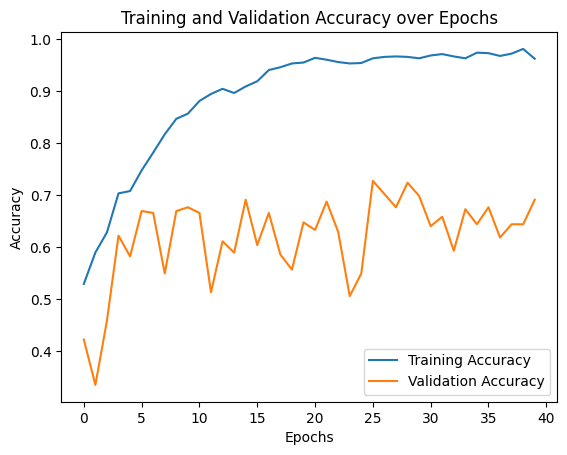

8/8 [==============================] - 1s 119ms/step - loss: 1.3164 - accuracy: 0.6774 - auc: 0.8212


In [166]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Testing code
test_accuracy = model_eff.evaluate(test_ds)


8/8 [==============================] - 4s 120ms/step
              precision    recall  f1-score   support

           0       0.75      0.74      0.75        82
           1       0.52      0.53      0.53        75
           2       0.74      0.74      0.74        91

    accuracy                           0.68       248
   macro avg       0.67      0.67      0.67       248
weighted avg       0.68      0.68      0.68       248



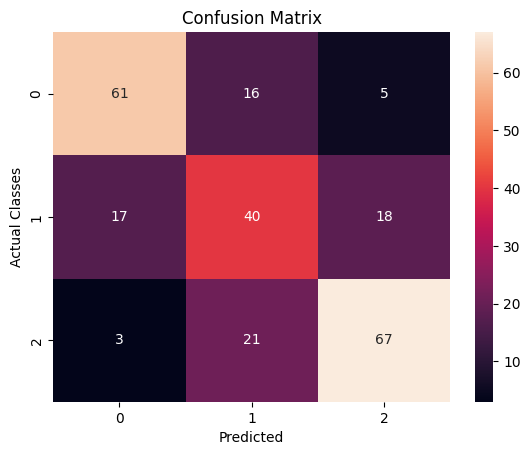

In [167]:
# Confusion matrix
true_labels = test_ds.classes
predictions = model_eff.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_labels))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [169]:
from sklearn.metrics import classification_report

# Assuming you have your test data generator named test_ds
# and class_labels is a list of your class labels

# Evaluate model
model_eval = model.evaluate(test_ds)
y_pred = model.predict(test_ds)
y_true = test_ds.classes
print("Model Metrics:")
print(model_eval)

# Generate classification report
class_report_model = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=cl)
print("Classification Report - Model:")
print(class_report_model)

# Repeat for model_4d
model_4d_eval = model_4d.evaluate(test_ds)
y_pred_4d = model_4d.predict(test_ds)
print("\nModel_4d Metrics:")
print(model_4d_eval)

class_report_model_4d = classification_report(y_true, np.argmax(y_pred_4d, axis=1), target_names=cl)
print("Classification Report - Model_4d:")
print(class_report_model_4d)

# Repeat for model_eff
model_eff_eval = model_eff.evaluate(test_ds)
y_pred_eff = model_eff.predict(test_ds)
print("\nModel_eff Metrics:")
print(model_eff_eval)

class_report_model_eff = classification_report(y_true, np.argmax(y_pred_eff, axis=1), target_names=cl)
print("Classification Report - Model_eff:")
print(class_report_model_eff)


8/8 [==============================] - 1s 102ms/step
Model Metrics:
[0.8539442420005798, 0.5967742204666138]
Classification Report - Model:
              precision    recall  f1-score   support

    01-minor       0.70      0.71      0.70        82
 02-moderate       0.43      0.37      0.40        75
   03-severe       0.62      0.68      0.65        91

    accuracy                           0.60       248
   macro avg       0.58      0.59      0.58       248
weighted avg       0.59      0.60      0.59       248

8/8 [==============================] - 1s 123ms/step

Model_4d Metrics:
[1.083669900894165, 0.6048387289047241, 0.8121788501739502]
Classification Report - Model_4d:
              precision    recall  f1-score   support

    01-minor       0.72      0.66      0.69        82
 02-moderate       0.44      0.41      0.42        75
   03-severe       0.64      0.71      0.67        91

    accuracy                           0.60       248
   macro avg       0.60      0.60      0.

In [170]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Assuming you have your test data generator named test_ds
# and class_labels is a list of your class labels

# Function to calculate precision, recall, f1-score, and accuracy
def calculate_metrics(model, test_ds, class_labels):
    y_pred = model.predict(test_ds)
    y_true = test_ds.classes
    accuracy = accuracy_score(y_true, np.argmax(y_pred, axis=1))
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1), average='weighted')
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    return metrics

# Calculate metrics for each model
metrics_model = calculate_metrics(model, test_ds, cl)
metrics_model_4d = calculate_metrics(model_4d, test_ds, cl)
metrics_model_eff = calculate_metrics(model_eff, test_ds, cl)

# Create a DataFrame
df = pd.DataFrame([metrics_model, metrics_model_4d, metrics_model_eff], index=['Model', 'Model_4d', 'Model_eff'])

# Display the DataFrame
print(df)


8/8 [==============================] - 1s 116ms/step
           Accuracy  Precision    Recall  F1 Score
Model      0.596774   0.588826  0.596774  0.591641
Model_4d   0.604839   0.603938  0.604839  0.603033
Model_eff  0.677419   0.679268  0.677419  0.678299
